In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import statsmodels.tsa.seasonal as sea
from dateutil.parser import parse
import tensorflow as tf

2023-05-04 11:00:35.407048: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-04 11:00:35.454517: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-04 11:00:35.456281: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-04 11:00:36.286176: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Loading data

In [2]:
dfs = {}

for file in Path("src").glob("*.csv"):
    print(f'Loading {file.name} [')
    
    s = file.name.split('_')[0]
    df = pd.read_csv(file.absolute())
    
    df.reset_index(inplace=True)
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df = df.sort_values('Datetime')
    df = df.set_index('Datetime')
    
    if s != 'pjm':
        mw_usage_column = df.columns[1]
        df = df.rename({mw_usage_column: 'Usage'}, axis='columns')
        df['Usage'] = df['Usage'] / max(df['Usage'])
    
    print(df.info)
    print(f'] {s}\n')
    
    if s == 'pjm':
        pjm = df
    else:
        dfs[s] = df

print(dfs.keys())

Loading PJME_hourly.csv [
<bound method DataFrame.info of                       index     Usage
Datetime                             
2002-01-01 01:00:00    8734  0.490139
2002-01-01 02:00:00    8735  0.471948
2002-01-01 03:00:00    8736  0.457305
2002-01-01 04:00:00    8737  0.449919
2002-01-01 05:00:00    8738  0.452467
...                     ...       ...
2018-08-02 20:00:00  140250  0.710494
2018-08-02 21:00:00  140251  0.697576
2018-08-02 22:00:00  140252  0.670096
2018-08-02 23:00:00  140253  0.620878
2018-08-03 00:00:00  140254  0.572272

[145366 rows x 2 columns]>
] PJME

Loading DOM_hourly.csv [
<bound method DataFrame.info of                       index     Usage
Datetime                             
2005-05-01 01:00:00    5855  0.332086
2005-05-01 02:00:00    5856  0.314212
2005-05-01 03:00:00    5857  0.304051
2005-05-01 04:00:00    5858  0.298000
2005-05-01 05:00:00    5859  0.297677
...                     ...       ...
2018-08-02 20:00:00  111073  0.648377
2018-08-02 21

## Concatenation

In [3]:
to_concat = []
for name, df in dfs.items():
    c = df.copy()
    c['Provider'] = name
    to_concat.append(c)
dfs['ALL'] = pd.concat(to_concat)
dfs['ALL']

,index,Usage,Provider
Datetime,,,
2002-01-01 01:00:00,8734,0.490139,PJME
2002-01-01 02:00:00,8735,0.471948,PJME
2002-01-01 03:00:00,8736,0.457305,PJME
2002-01-01 04:00:00,8737,0.449919,PJME
2002-01-01 05:00:00,8738,0.452467,PJME
...,...,...,...
2018-08-02 20:00:00,113952,0.643746,DUQ
2018-08-02 21:00:00,113953,0.636542,DUQ
2018-08-02 22:00:00,113954,0.622462,DUQ


<Axes: xlabel='Datetime'>

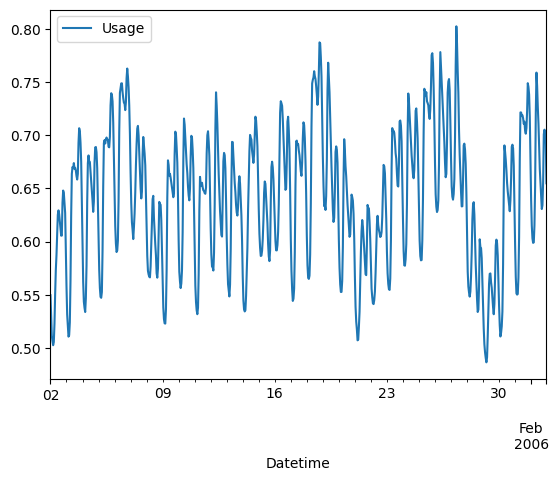

In [4]:
dfs['AEP']['2006-01-02':'2006-02-01'].plot(y='Usage')

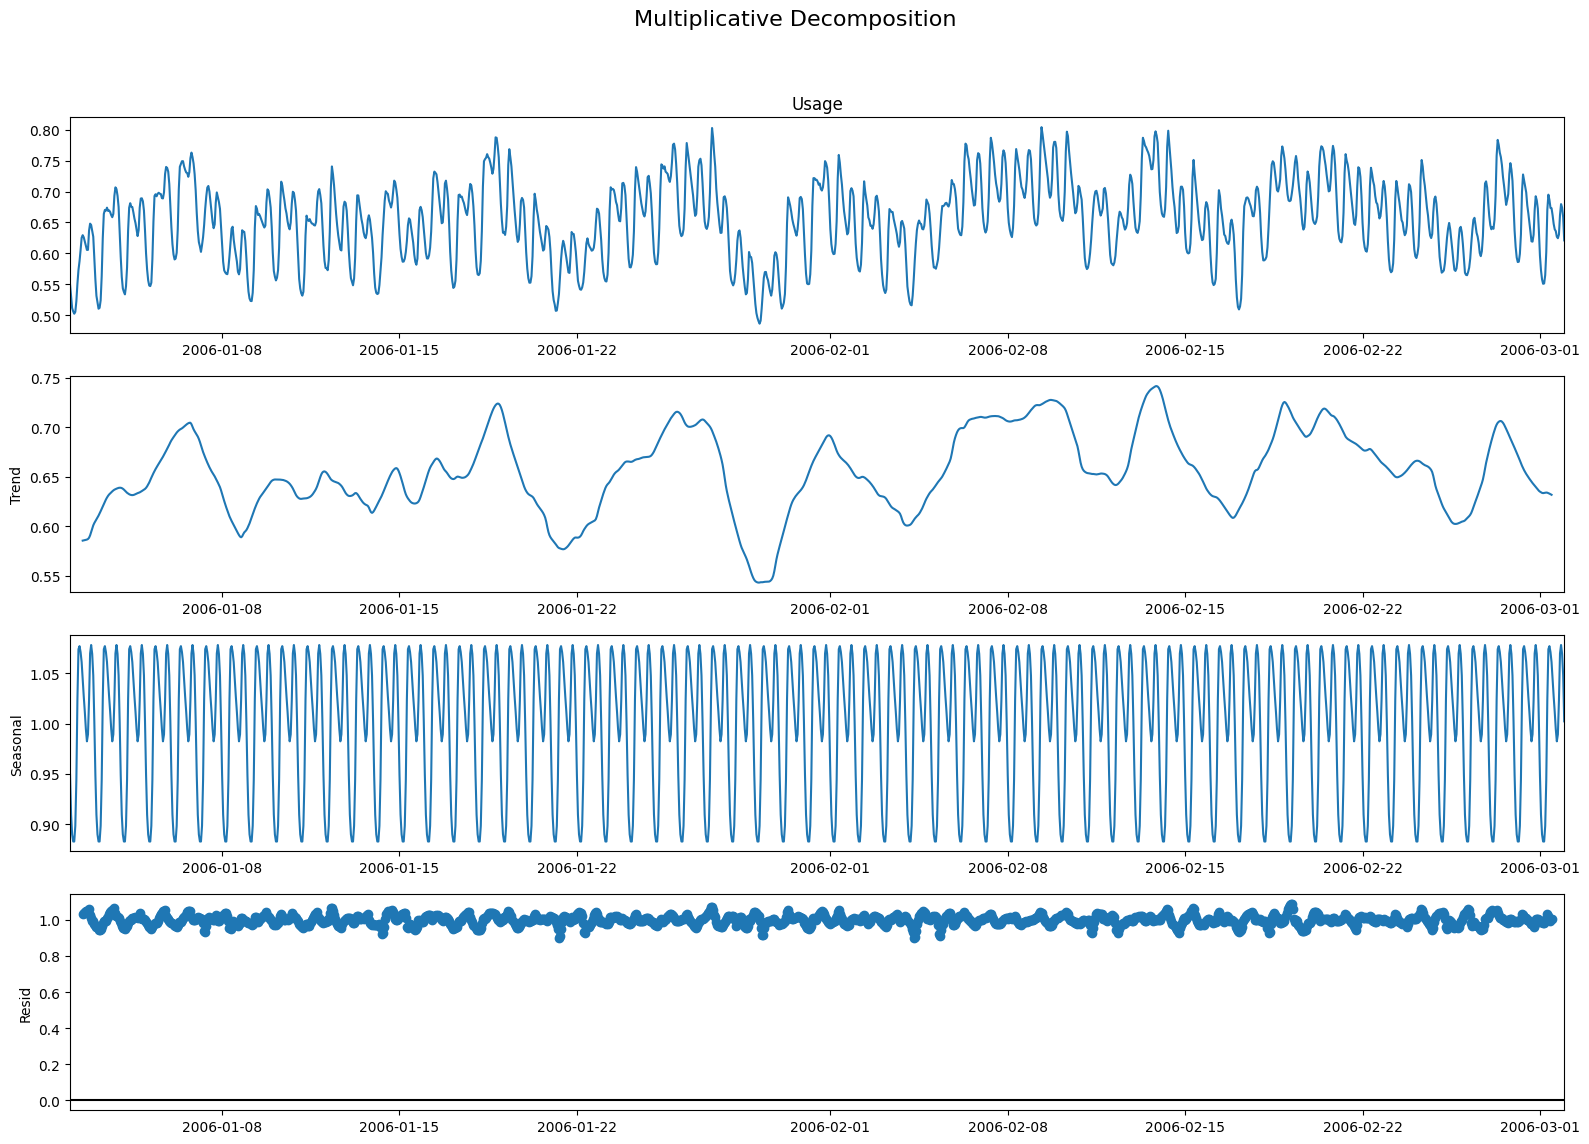

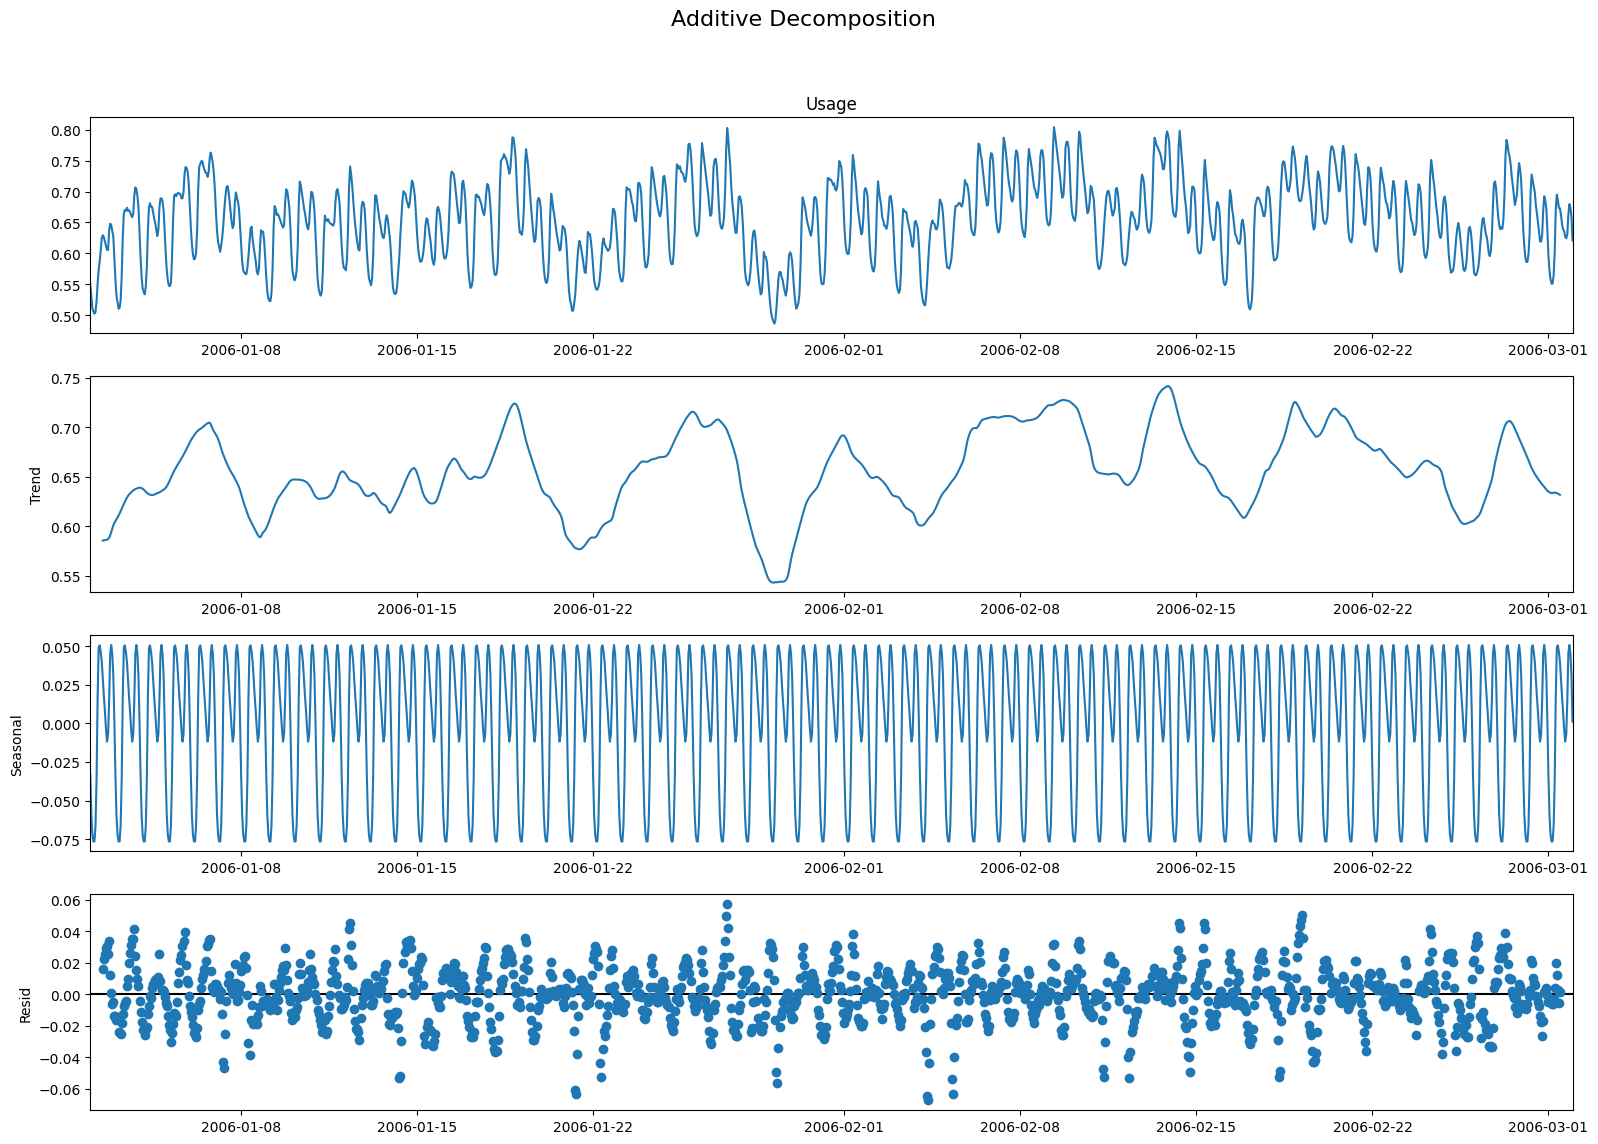

In [5]:
def decompose(df):
    # Multiplicative Decomposition 
    mul = sea.seasonal_decompose(df['Usage'], period=24, model='multiplicative')
    
    # Additive Decomposition
    add = sea.seasonal_decompose(df['Usage'], period=24, model='additive')
    
    # Plot
    plt.rcParams.update({'figure.figsize': (16,12)})
    mul.plot().suptitle('Multiplicative Decomposition', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    add.plot().suptitle('Additive Decomposition', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    plt.show()

decompose(dfs['AEP']['2006-01-02':'2006-03-01'])

In [6]:
def prepare_data(df, in_size=10*24, out_size=1):
    current = df.index[0]
    maxd = df.index.max()
    hour = pd.Timedelta(1, unit='H')
    in_delta = in_size * hour
    out_delta = out_size * hour
    inputs = []
    outputs = []
    while True:
        end = current + in_delta - hour
        in_values = df[current:end].to_numpy()[...,1]
        while len(in_values) != in_size and end <= maxd:
            end += hour
            in_values = df[current:end].to_numpy()[...,1]
        current = end + hour
        end = current + out_delta - hour
        out_values = df[current:end].to_numpy()[...,1]
        while len(out_values) != out_size and end <= maxd:
            end += hour
            in_values = df[current:end].to_numpy()[...,1]
        current = end + hour
        
        if len(out_values) < out_size:
            break

        inputs.append(in_values)
        outputs.append(out_values)
    
    train_count = (len(inputs) * 80) // 100
    tr_x, te_x = inputs[train_count:], inputs[:train_count]
    tr_y, te_y = outputs[train_count:], outputs[:train_count]
    return np.array(tr_x), np.array(te_x), np.array(tr_y), np.array(te_y) 

In [7]:
def construct_model(x, y, path_to_save=None):
    in_size = len(x[0])
    out_size = len(y[0])
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(in_size, activation='relu'),
        tf.keras.layers.Dense(in_size, activation='relu'),
        tf.keras.layers.Dense(out_size)
    ])
    model.compile(optimizer='adam',
              loss='mean_absolute_error')
    model.fit(x, y, epochs=200, validation_split=0.2, verbose=False)
    
    if path_to_save is not None:
        model.save(path_to_save)
    
    model.summary()
    return model

In [8]:
tr_x, te_x, tr_y, te_y = prepare_data(dfs['DOM'])

In [9]:
model = construct_model(tr_x, tr_y, "/tmp/model")
model.evaluate(te_x, te_y, verbose=0)

INFO:tensorflow:Assets written to: /tmp/model/assets


INFO:tensorflow:Assets written to: /tmp/model/assets


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 240)               57840     
                                                                 
 dense_1 (Dense)             (None, 240)               57840     
                                                                 
 dense_2 (Dense)             (None, 1)                 241       
                                                                 
Total params: 115,921
Trainable params: 115,921
Non-trainable params: 0
_________________________________________________________________


0.035722728818655014

9/9 [==============================] - 0s 1ms/step


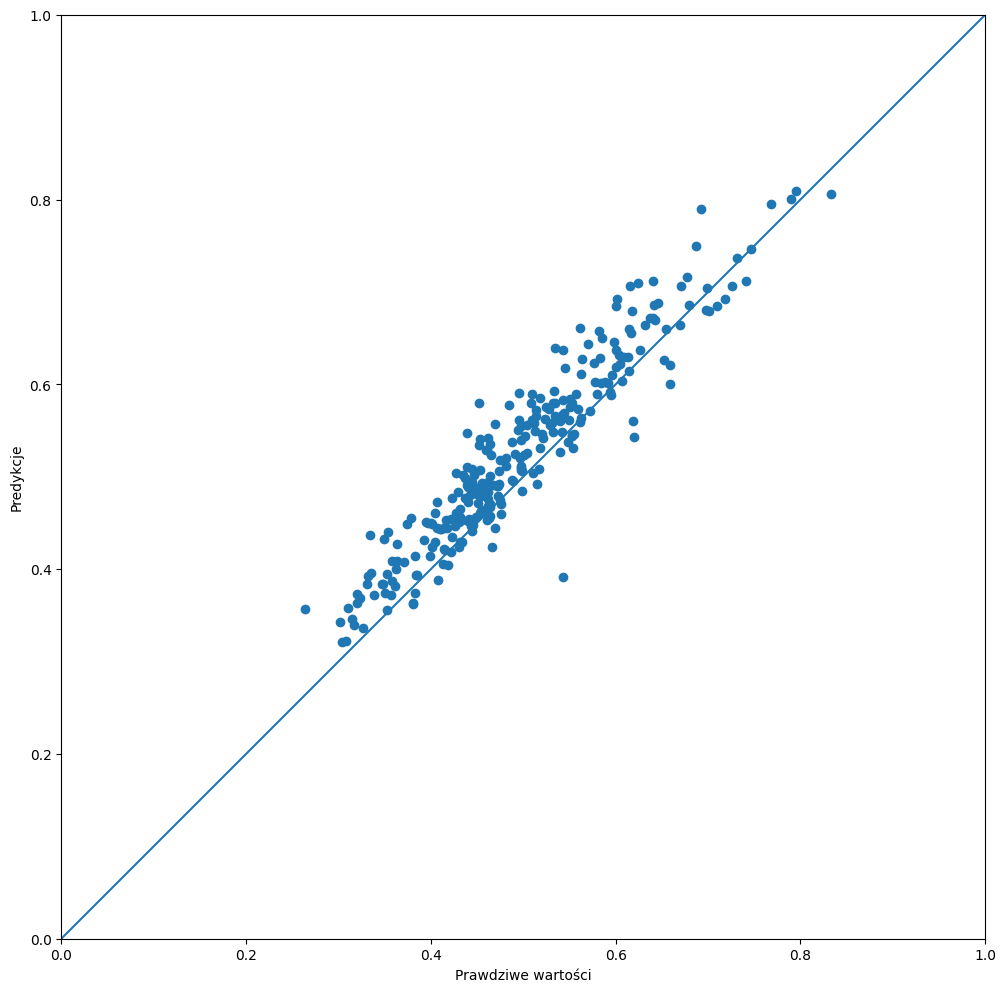

In [10]:
test_predictions = model.predict(te_x).flatten()

a = plt.axes(aspect='equal')
plt.scatter(te_y, test_predictions)
plt.xlabel('Prawdziwe wartości')
plt.ylabel('Predykcje')
lims = [0, 1]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [11]:
def krysztalowa_kula(model, real_y, predict, in_size):
    y = list(real_y)[:-predict]
    for i in range(predict):
        inp = np.array([y[-in_size:]])
        value = model.predict(inp, verbose=False).flatten()[0]
        y.append(value)
    x = list(range(len(real_y)))
    plt.plot(x[-predict*2:], y[-predict*2:], label='Predykcja')
    plt.plot(x[-predict*2:], real_y[-predict*2:], label='Prawdziwe wartości')
    plt.scatter(len(x)-predict-1, real_y[len(x)-predict-1], c='r', label='Start')
    plt.legend()
    plt.show()

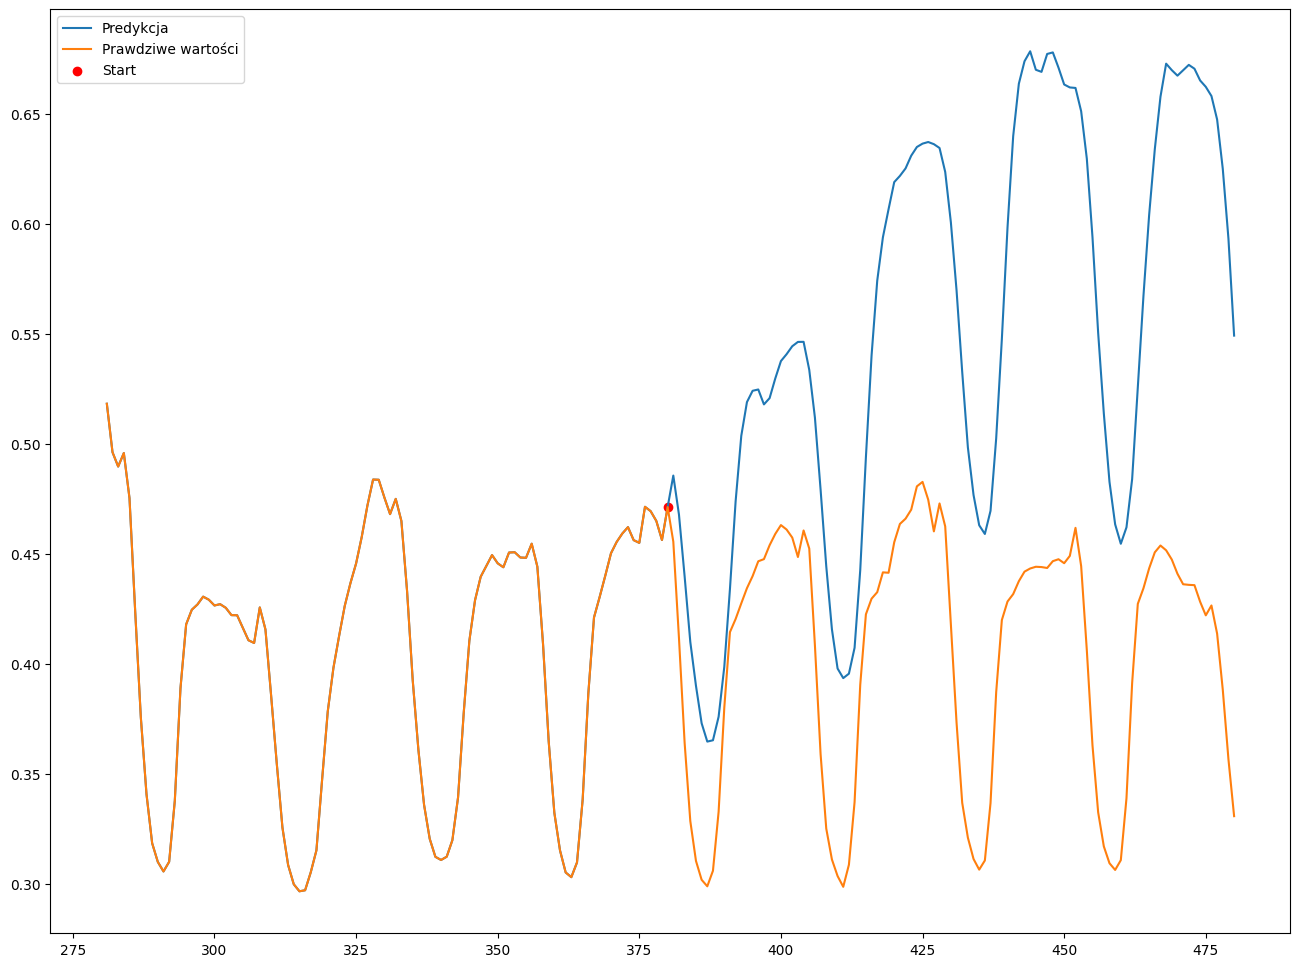

In [12]:
krysztalowa_kula(model, list(te_x[0])+list(te_y[0])+list(te_x[1]), 100, 10*24)